# Projeto de Machine Learning II
Projeto final do curso de Machine Learning II da Turma Santander Coders 2023 - Trilha de Data Science - Turma 1008.

Integrantes:
- [Anna Clara Amâncio](https://github.com/claraamancio)
- [Manusa Leal](https://github.com/manusaleal)

Este projeto possui como objetivo a realização da segmentação de clientes através de modelos não supervisionados.
A segmentação de clientes é importante para áreas como marketing e vendas dentro das empresas, pois desta forma é possível criar campanhas e melhores táticas de vendas com uma assertividade melhor.

O dataset possui informações demográficas relevantes dos clientes, sendo elas:

- Sexo biológico: 0: Masculino, 1: Feminino
- Estado civil: 0: Solteiro, 1: Não solteiro (divorciado/separado/casado/viúvo)
- Idade: Valor mínimo de 18, valor máximo de 78
- Educação: 0: outro/desconhecido, 1: ensino médio, 2: universidade, 3: pós-graduação
- Renda: Renda anual autodeclarada em dólares americanos do cliente (USD 35832 Valor mínimo e USD 309364 Valor máximo)
- Ocupação: 0: desempregado/não qualificado, 1: funcionário qualificado, 2: funcionário altamente qualificado
- Tamanho do assentamento (tamanho da cidade que o cliente reside baseado na quantidade de pessoas): 0: cidade pequena, 1: cidade média, 2: cidade grande

# 1. Preparação dos Dados e Verificação de Consistência

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('segmentation data.csv')
df = pd.DataFrame(data)
df

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0
3,100000004,0,0,45,1,171565,1,1
4,100000005,0,0,53,1,149031,1,1
...,...,...,...,...,...,...,...,...
1995,100001996,1,0,47,1,123525,0,0
1996,100001997,1,1,27,1,117744,1,0
1997,100001998,0,0,31,0,86400,0,0
1998,100001999,1,1,24,1,97968,0,0


In [3]:
df.shape

(2000, 8)

In [4]:
df.columns

Index(['ID', 'Sex', 'Marital status', 'Age', 'Education', 'Income',
       'Occupation', 'Settlement size'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ID               2000 non-null   int64
 1   Sex              2000 non-null   int64
 2   Marital status   2000 non-null   int64
 3   Age              2000 non-null   int64
 4   Education        2000 non-null   int64
 5   Income           2000 non-null   int64
 6   Occupation       2000 non-null   int64
 7   Settlement size  2000 non-null   int64
dtypes: int64(8)
memory usage: 125.1 KB


In [6]:
df.describe()

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2.000000e+03,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,1.000010e+08,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,5.774946e+02,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,1.000000e+08,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,1.000005e+08,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,1.000010e+08,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000015e+08,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000020e+08,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


# Análise Exploratória de Dados

In [7]:
#Criando uma função para substituir os labels para os gráficos
def temp_df(df):
    temp_df = df.copy()
    temp_df = temp_df.rename(columns={"Sex": "Sexo", "Marital status": "Estado Civil", "Education": "Educação", 
                                      "Occupation": "Ocupação", "Settlement size": "Tamanho do Assentamento",
                                      "Age": "Idade", "Income": "Renda"})
    temp_df['Sexo'] = temp_df['Sexo'].replace(0, 'Masculino')
    temp_df['Sexo'] = temp_df['Sexo'].replace(1, 'Feminino')
    temp_df['Estado Civil'] = temp_df['Estado Civil'].replace(0, 'Solteiro')
    temp_df['Estado Civil'] = temp_df['Estado Civil'].replace(1, 'Não Solteiro')
    temp_df['Educação'] = temp_df['Educação'].replace(0, 'Outro/Desconhecido')
    temp_df['Educação'] = temp_df['Educação'].replace(1, 'Ensino Médio')
    temp_df['Educação'] = temp_df['Educação'].replace(2, 'Universidade')
    temp_df['Educação'] = temp_df['Educação'].replace(3, 'Pós-graduação')
    temp_df['Ocupação'] = temp_df['Ocupação'].replace(0, 'Desempregado/Não qualificado')
    temp_df['Ocupação'] = temp_df['Ocupação'].replace(1, 'Funcionário qualificado')
    temp_df['Ocupação'] = temp_df['Ocupação'].replace(2, 'Funcionário altamente qualificado')
    temp_df['Tamanho do Assentamento'] = temp_df['Tamanho do Assentamento'].replace(0, 'Cidade Pequena')
    temp_df['Tamanho do Assentamento'] = temp_df['Tamanho do Assentamento'].replace(1, 'Cidade Média')
    temp_df['Tamanho do Assentamento'] = temp_df['Tamanho do Assentamento'].replace(2, 'Cidade Grande')
    return temp_df

In [8]:
df_eda = temp_df(df)

In [9]:
df_eda

,ID,Sexo,Estado Civil,Idade,Educação,Renda,Ocupação,Tamanho do Assentamento
0,100000001,Masculino,Solteiro,67,Universidade,124670,Funcionário qualificado,Cidade Grande
1,100000002,Feminino,Não Solteiro,22,Ensino Médio,150773,Funcionário qualificado,Cidade Grande
2,100000003,Masculino,Solteiro,49,Ensino Médio,89210,Desempregado/Não qualificado,Cidade Pequena
3,100000004,Masculino,Solteiro,45,Ensino Médio,171565,Funcionário qualificado,Cidade Média
4,100000005,Masculino,Solteiro,53,Ensino Médio,149031,Funcionário qualificado,Cidade Média
...,...,...,...,...,...,...,...,...
1995,100001996,Feminino,Solteiro,47,Ensino Médio,123525,Desempregado/Não qualificado,Cidade Pequena
1996,100001997,Feminino,Não Solteiro,27,Ensino Médio,117744,Funcionário qualificado,Cidade Pequena
1997,100001998,Masculino,Solteiro,31,Outro/Desconhecido,86400,Desempregado/Não qualificado,Cidade Pequena
1998,100001999,Feminino,Não Solteiro,24,Ensino Médio,97968,Desempregado/Não qualificado,Cidade Pequena


### Distribuição das Variáveis Categóricas

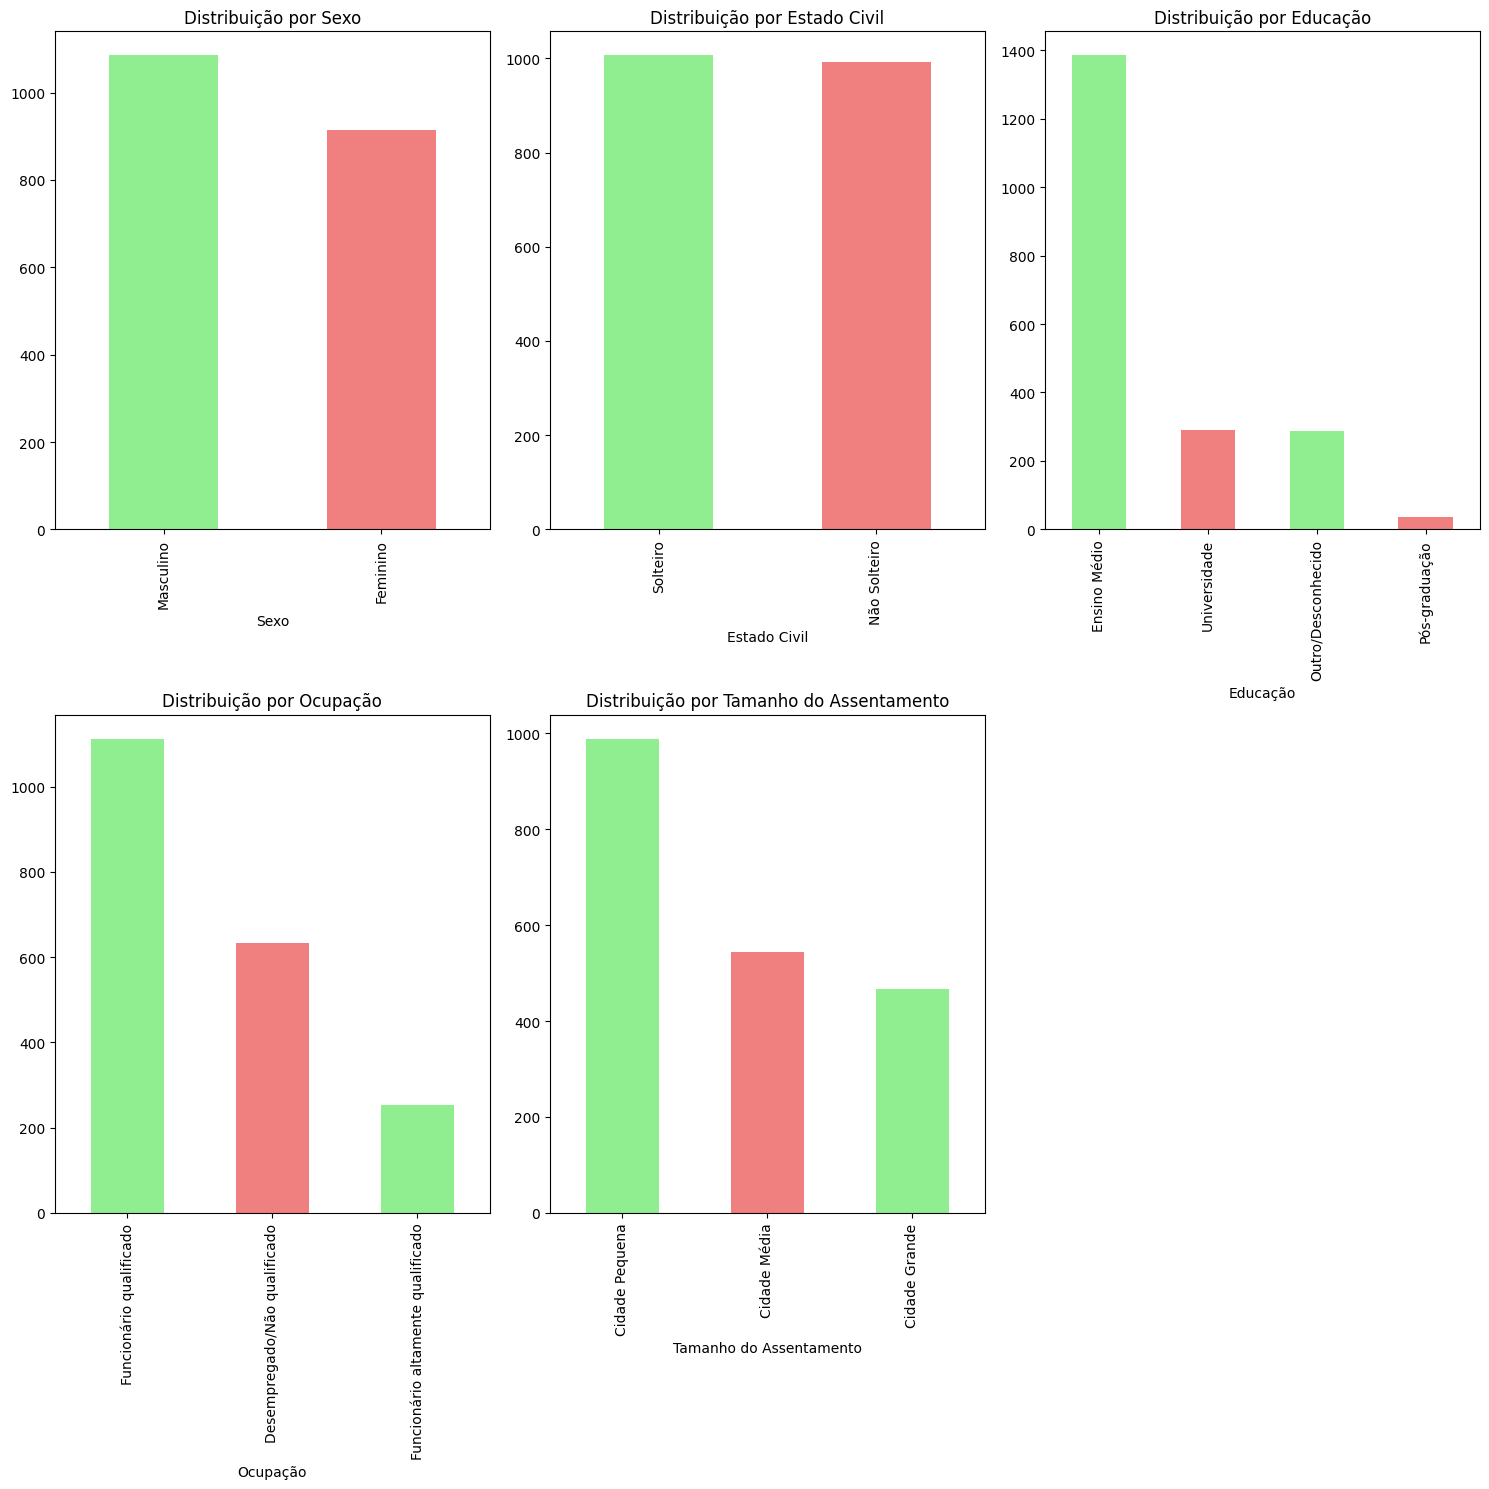

In [10]:
# Contando a ocorrência para cada categoria
sexo_counts = df_eda['Sexo'].value_counts()
estado_civil_counts = df_eda['Estado Civil'].value_counts()
educacao_counts = df_eda['Educação'].value_counts()
ocupacao_counts = df_eda['Ocupação'].value_counts()
assentamento_counts = df_eda['Tamanho do Assentamento'].value_counts()

paleta = ['lightgreen', 'lightcoral']

# Criando os subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))

# Plot para 'Sexo'
sexo_counts.plot(kind='bar', ax=axes[0, 0], color=paleta)
axes[0, 0].set_title('Distribuição por Sexo')

# Plot para 'Estado Civil'
estado_civil_counts.plot(kind='bar', ax=axes[0, 1], color=paleta)
axes[0, 1].set_title('Distribuição por Estado Civil')

# Plot para 'Educação'
educacao_counts.plot(kind='bar', ax=axes[0, 2], color=paleta)
axes[0, 2].set_title('Distribuição por Educação')

# Plot para 'Ocupação'
ocupacao_counts.plot(kind='bar', ax=axes[1, 0], color=paleta)
axes[1, 0].set_title('Distribuição por Ocupação')

# Plot para 'Tamanho do Assentamento'
assentamento_counts.plot(kind='bar', ax=axes[1, 1], color=paleta)
axes[1, 1].set_title('Distribuição por Tamanho do Assentamento')

# Removendo subplots vazios
fig.delaxes(axes[1, 2])

# Ajuste de layout
plt.tight_layout()
plt.show()

- A Distribuição por Estado Civil é a que possui uma proporção melhor balanceada, seguida pelo Sexo. 

- Já a Educação, Ocupação e tamanho do Assentamento estão desbalanceados. 
- Na distribuição da Educação, grande quantidade de pessoas que possuem o Ensino Médio e menos de 50 pessoas possuem a pós graduação.

- Para a Ocupação, muitos funcionários qualificados e muitas pessoas são de Cidade Pequena.

### Distribuição das Variáveis Numéricas

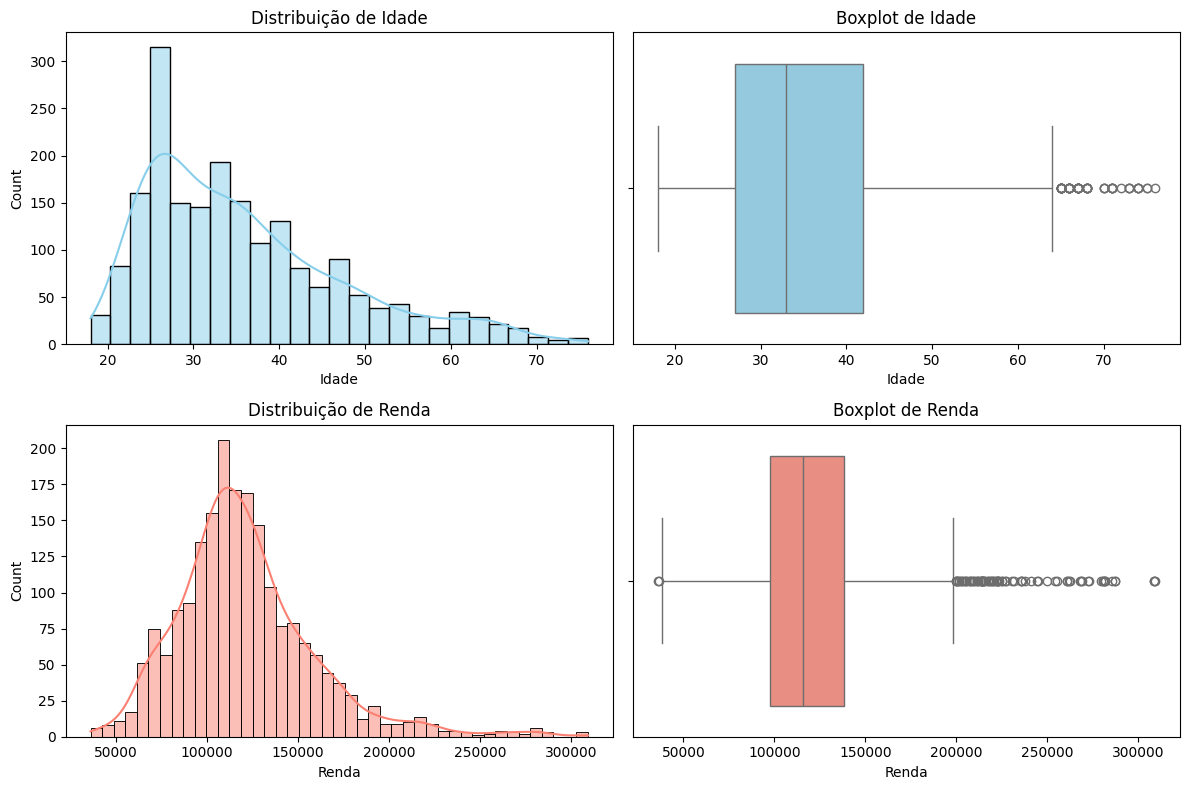

In [11]:
# Create a figure with two subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Distribution plot for 'Idade'
sns.histplot(df_eda['Idade'], kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Distribuição de Idade')

# Boxplot for 'Idade'
sns.boxplot(x=df_eda['Idade'], ax=axes[0, 1], color='skyblue')
axes[0, 1].set_title('Boxplot de Idade')

# Distribution plot for 'Renda'
sns.histplot(df_eda['Renda'], kde=True, ax=axes[1, 0], color='salmon')
axes[1, 0].set_title('Distribuição de Renda')

# Boxplot for 'Renda'
sns.boxplot(x=df_eda['Renda'], ax=axes[1, 1], color='salmon')
axes[1, 1].set_title('Boxplot de Renda')

# Adjust layout
plt.tight_layout()
plt.show()

In [14]:
#Valores exatos da média e mediana
numeric_columns = df_eda[['Idade', 'Renda']]
numeric_columns.describe()

,Idade,Renda
count,2000.000000,2000.000000
mean,35.909000,120954.419000
std,11.719402,38108.824679
min,18.000000,35832.000000
25%,27.000000,97663.250000
50%,33.000000,115548.500000
75%,42.000000,138072.250000
max,76.000000,309364.000000


Observando a distribuição de idade, temos que o gráfico está deslocado para a esquerda, indicando que a média (35.9) é maior que a mediana. O boxplot indica que a mediana está próxima dos 33 anos, contendo alguns outliers no limite superior.

Já para a distribuição de renda, ela está levemente desloacada para a esquerda, tendo um boxplot com distribuição um pouco mais simétrico do que a idade. A maioria dos outliers estão no limite superior.

# Modelos de Clusterização não supervisionado